In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sympy as sp
from scipy.integrate import solve_ivp

sp.init_printing(use_latex=True)

# %matplotlib qt


In [3]:
t = sp.symbols("t")
x, y, z = sp.symbols("x y z", cls=sp.Function)
mu, a0 = sp.symbols(r"\mu a0")
n0 = sp.sqrt(mu / (a0 ** 3))
n = sp.symbols("n")


In [4]:
xt, yt, zt = sp.symbols("xt yt zt", cls=sp.Function)


In [5]:
r0 = (600 + 6378) * 1000
n0 = n0.evalf(subs={a0: r0, mu: 3.986e14})


In [6]:
x0, y0, z0, xt0, yt0, zt0 = sp.symbols("x0 y0 z0 xt0 yt0 zt0")


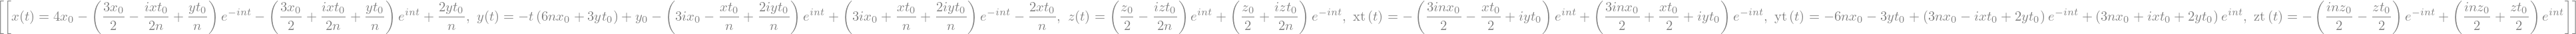

In [7]:
# linear model
eqs = [sp.Eq(xt(t), x(t).diff(t)),
       sp.Eq(yt(t), y(t).diff(t)),
       sp.Eq(zt(t), z(t).diff(t)),
       sp.Eq(xt(t).diff(t) - 2 * n * y(t).diff(t) - 3 * n**2 * x(t), 0),
       sp.Eq(yt(t).diff(t) + 2 * n * x(t).diff(t), 0),
       sp.Eq(zt(t).diff(t) + n**2 * z(t), 0)]

general_solution = sp.solvers.ode.systems.dsolve_system(eqs, ics={x(0): x0, y(0): y0, z(0): z0,
                                                                  xt(0): xt0, yt(0): yt0, zt(0): zt0})

solution = sp.solvers.ode.systems.dsolve_system([eq.evalf(subs={n: n0}) for eq in eqs], ics={x(0): 69780, y(0): 139560, z(0): 104670,
                                                xt(0): 7.5579, yt(0): -151.116, zt(0): 15.116}, )  # example of initial conditions is taken from page 89

# for some internal reasons sympy outputs complex numbers in the solution, it should not be so. Although the computational solution (if we previously substitute "n") is right
general_solution


In [8]:
chief_orbit = [sp.Eq(x(t), a0 * sp.cos(n * t)),
               sp.Eq(y(t), a0 * sp.sin(n * t)), sp.Eq(z(t), 0)]
chief_orbit


In [9]:
t_span = np.linspace(0, 2*np.pi/float(n0), 1000)
chief_orbit_plot = np.array([np.array([chief_orbit[0].rhs.evalf(subs={t: ti, a0: r0}) for ti in t_span]),
                             np.array([chief_orbit[1].rhs.evalf(
                                 subs={t: ti, a0: r0}) for ti in t_span]),
                             np.array([chief_orbit[2].rhs.evalf(subs={t: ti, a0: r0}) for ti in t_span])])
rho = np.array([np.array([solution[0][0].rhs.evalf(subs={t: ti, a0: r0}) for ti in t_span]),
                np.array([solution[0][1].rhs.evalf(
                    subs={t: ti, a0: r0}) for ti in t_span]),
                np.array([solution[0][2].rhs.evalf(subs={t: ti, a0: r0}) for ti in t_span])])


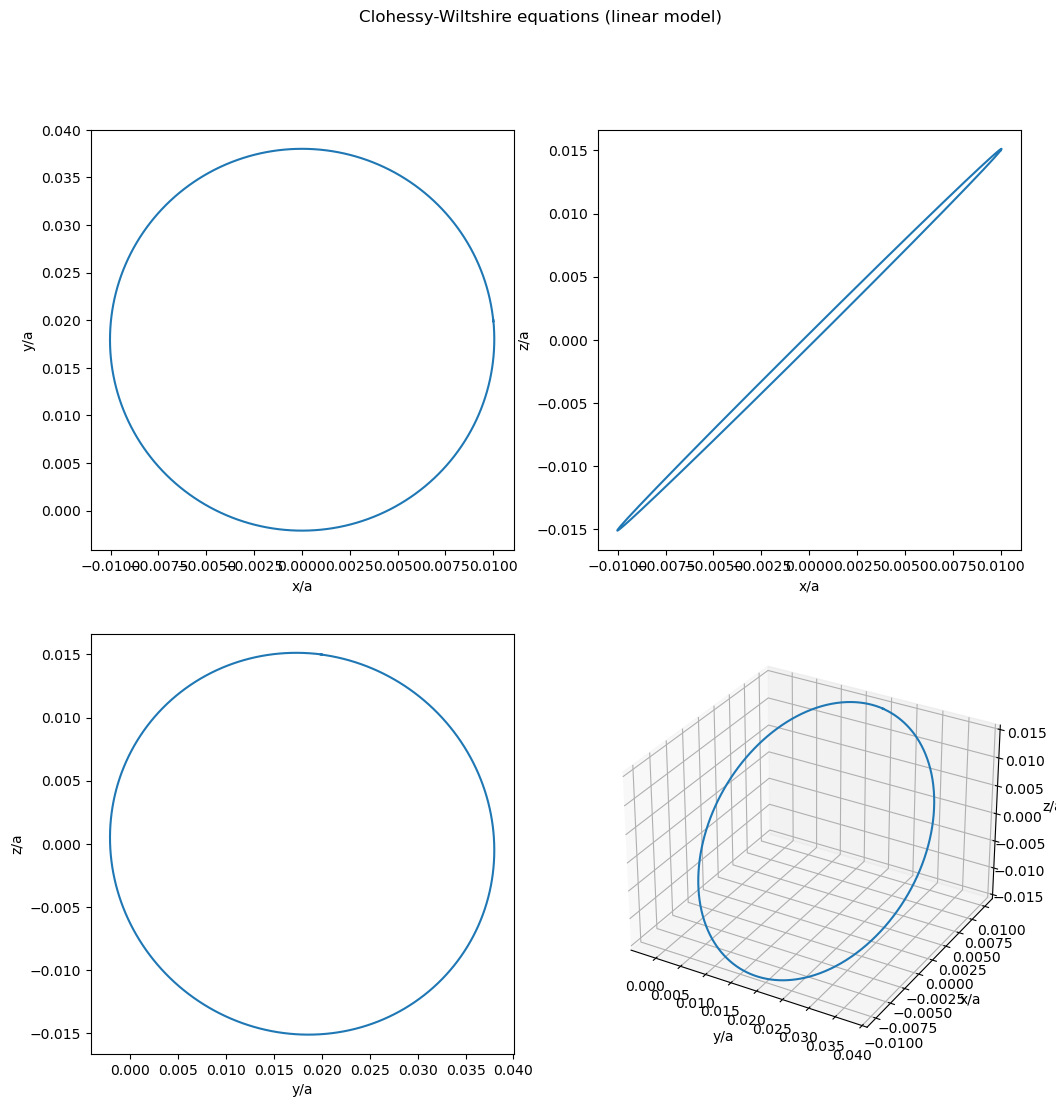

In [10]:
fig = plt.figure(figsize=(12, 12), dpi=100)
fig.suptitle("Clohessy-Wiltshire equations (linear model)")

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(rho[0] / r0, rho[1] / r0)
ax1.set_xlabel("x/a")
ax1.set_ylabel("y/a")

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(rho[0] / r0, rho[2] / r0)
ax2.set_xlabel("x/a")
ax2.set_ylabel("z/a")

ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(rho[1] / r0, rho[2] / r0)
ax3.set_xlabel("y/a")
ax3.set_ylabel("z/a")

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot3D(rho[1] / r0, rho[0] / r0, rho[2] / r0)
ax4.set_xlabel("y/a")
ax4.set_ylabel("x/a")
ax4.set_zlabel("z/a")


#ax.legend(loc="upper left")
plt.show()


In [11]:
# non-linear model
#y = [x, y, z, xt, yt, zt]
def CWfunc(t, mas, n, mu, a0):
    out = np.zeros(6)
    x, y, z, xt, yt, zt = mas

    out[0] = xt
    out[1] = yt
    out[2] = zt

    out[3] = 2 * n * yt + n**2 * x - \
        (mu * (a0 + x)) / ((a0 + x)**2 + y**2 + z**2)**(3/2) + mu / a0**2
    out[4] = -2 * n * xt + n**2 * y - \
        (mu * y) / ((a0 + x)**2 + y**2 + z**2)**(3/2)
    out[5] = -(mu * z) / ((a0 + x)**2 + y**2 + z**2)**(3/2)

    return out


mas0 = [69780, 139560, 104670, 7.5579, -151.116, 15.116]

solution = solve_ivp(CWfunc, (0, 2 * (2*np.pi/float(n0))), mas0,
                     args=(n0, 3.986e14, r0), max_step=(2*np.pi/float(n0)/1000))

print("number of samples: ", len(solution.t))

solution


number of samples:  2003


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.855e-01 ...  1.160e+04  1.160e+04]
        y: [[ 6.978e+04  6.978e+04 ...  7.102e+04  7.104e+04]
            [ 1.396e+05  1.395e+05 ...  2.464e+04  2.424e+04]
            ...
            [-1.511e+02 -1.511e+02 ... -1.510e+02 -1.510e+02]
            [ 1.512e+01  1.508e+01 ...  1.726e+01  1.695e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 12014
     njev: 0
      nlu: 0

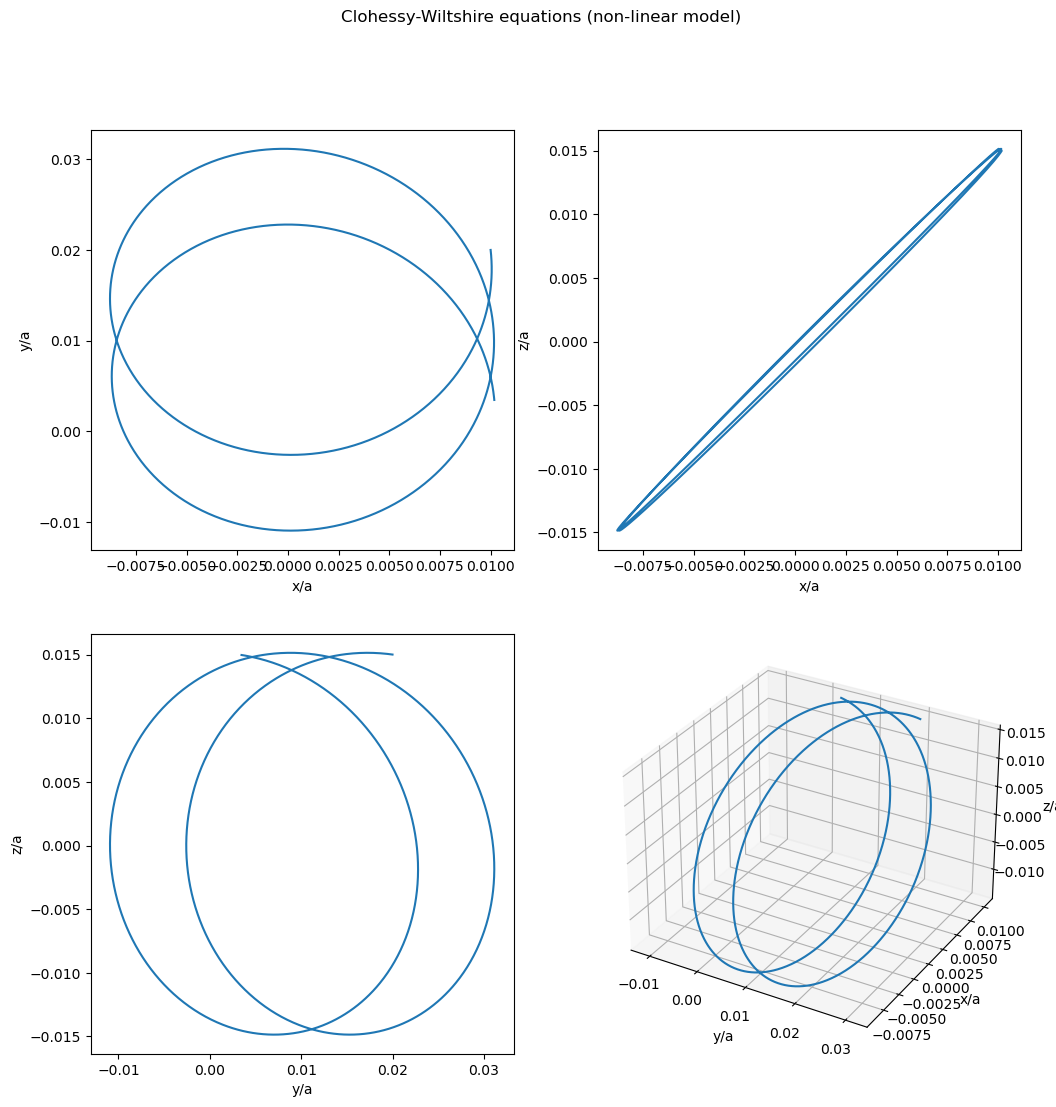

In [12]:
fig = plt.figure(figsize=(12, 12), dpi=100)
fig.suptitle("Clohessy-Wiltshire equations (non-linear model)")

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(solution.y[0] / r0, solution.y[1] / r0)
ax1.set_xlabel("x/a")
ax1.set_ylabel("y/a")

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(solution.y[0] / r0, solution.y[2] / r0)
ax2.set_xlabel("x/a")
ax2.set_ylabel("z/a")

ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(solution.y[1] / r0, solution.y[2] / r0)
ax3.set_xlabel("y/a")
ax3.set_ylabel("z/a")

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot3D(solution.y[1] / r0, solution.y[0] / r0, solution.y[2] / r0)
ax4.set_xlabel("y/a")
ax4.set_ylabel("x/a")
ax4.set_zlabel("z/a")

plt.show()


In [13]:
# linear model with ode
# mas = [/*realtive orbit*/ x, y, z, xt, yt, zt, /*chief position*/ x1, y1, z1, xt1, yt1, zt1]
def CWfunc(t, mas, n):
    out = np.zeros(12)
    x, y, z, xt, yt, zt, x1, y1, z1, xt1, yt1, zt1 = mas

    out[0] = xt
    out[1] = yt
    out[2] = zt

    out[3] = 2 * n * yt + 3 * n**2 * x
    out[4] = -2 * n * xt
    out[5] = - n**2 * z

    out[6] = xt1
    out[7] = yt1
    out[8] = zt1

    out[9] = - n**2 * x1
    out[10] = - n**2 * y1
    out[11] = - n**2 * z1

    return out


mas0 = [69780, 139560, 104670, 7.5579, -
        151.116, 15.116, r0, 0, 0, 0, r0 * n0, 0]

solution = solve_ivp(CWfunc, (0, (2*np.pi/float(n0))), mas0,
                     args=(n0,), max_step=(2*np.pi/float(n0)/1000))

print("number of samples: ", len(solution.t))

solution


number of samples:  1009


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.742e-07 ...  5.799e+03  5.801e+03]
        y: [[69780 69780.00000282834 ... 69767.47177178036
             69779.99999999862]
            [139560 139559.99994344893 ... 139065.0766984745
             138816.81061355976]
            ...
            [7557.93520992552 7557.935209925521 ... 7557.923242268907
             7557.9352099253965]
            [0 0.0 ... 0.0 0.0]]
      sol: None
 t_events: None
 y_events: None
     nfev: 6050
     njev: 0
      nlu: 0

In [14]:
#calculating deputy position in ECI
deputy_pos = np.empty((3, 0))

for x, y, z, x1, y1, z1, xt1, yt1, zt1 in zip(solution.y[0], solution.y[1], solution.y[2], solution.y[6], solution.y[7], solution.y[8], solution.y[9], solution.y[10], solution.y[11]):
    ez = np.array([x1, y1, z1])
    ez = ez / np.linalg.norm(ez)
    ey = np.cross([x1, y1, z1], [xt1, yt1, zt1])
    ey = ey / np.linalg.norm(np.double(ey))
    ex = np.cross(ey, ez)

    A = np.vstack((ez, ex, ey)).T

    x0, y0, z0 = (A @ np.array([[x], [y], [z]]) + np.array([[x1], [y1], [z1]])).T[0]

    deputy_pos = np.concatenate((deputy_pos, [[x0], [y0], [z0]]), axis=1)
    

[0 1.00000000000000 0]
[0 0.0 1.00000000000000]
[1. 0. 0.]
[[1.0 0 0]
 [0.0 1.00000000000000 0.0]
 [0.0 0 1.00000000000000]]
[[ 69780]
 [139560]
 [104670]]
[[69780.0000000000]
 [139560.000000000]
 [104670.000000000]]
[-4.05324292e-10  1.00000000e+00  0.00000000e+00]
[ 0. -0.  1.]
[1.00000000e+00 4.05324292e-10 0.00000000e+00]
[[ 1.00000000e+00 -4.05324292e-10  0.00000000e+00]
 [ 4.05324292e-10  1.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 69780.00000283]
 [139559.99994345]
 [104670.00000566]]
[[ 69779.99994626]
 [139559.99997173]
 [104670.00000566]]
[-4.45856721e-09  1.00000000e+00  0.00000000e+00]
[ 0. -0.  1.]
[1.00000000e+00 4.45856721e-09 0.00000000e+00]
[[ 1.00000000e+00 -4.45856721e-09  0.00000000e+00]
 [ 4.45856721e-09  1.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 69780.00003111]
 [139559.99937794]
 [104670.00006222]]
[[ 69779.99940887]
 [139559.99968906]
 [104670.00006222]]
[-4.49909964e-08  1.0

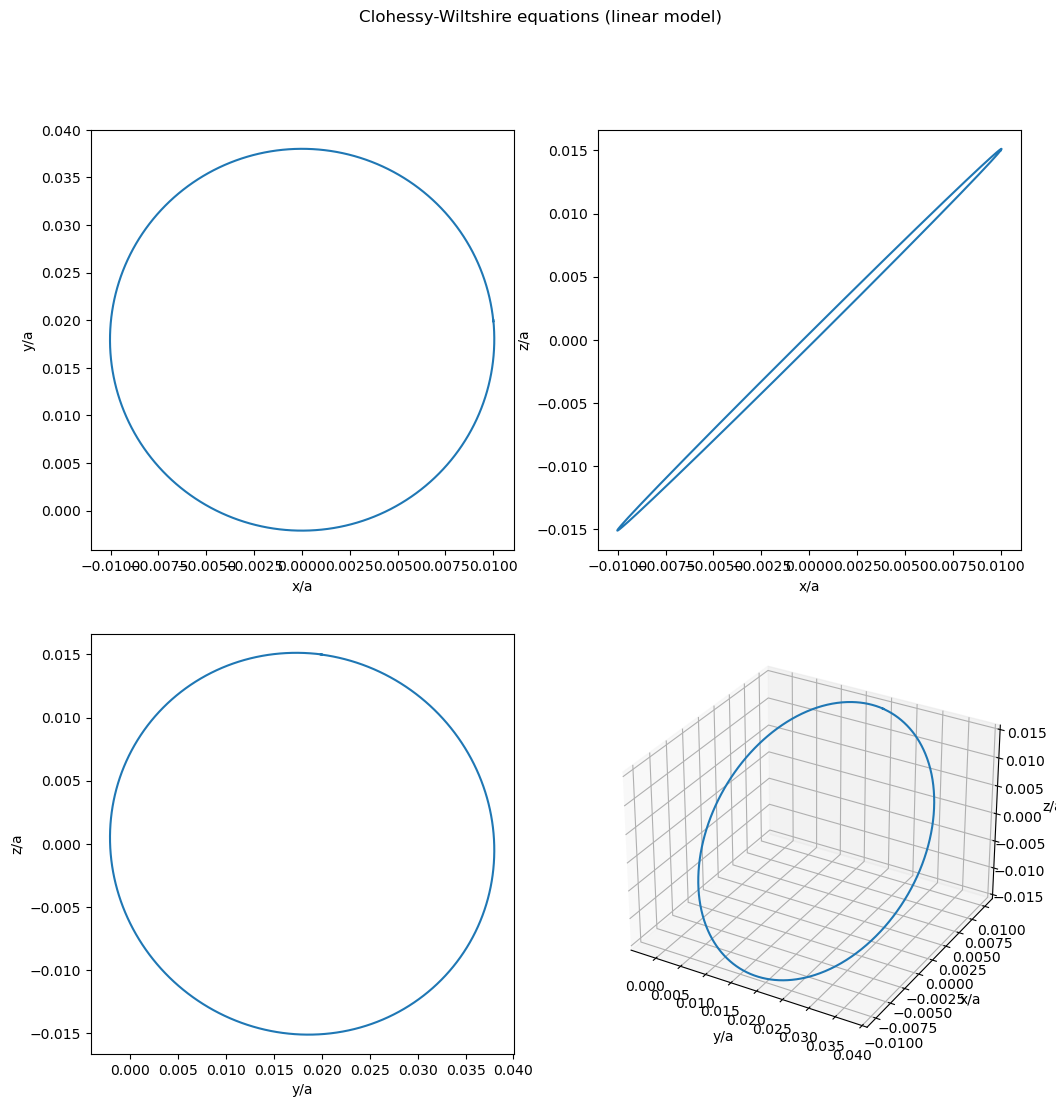

In [15]:
fig = plt.figure(figsize=(12, 12), dpi=100)
fig.suptitle("Clohessy-Wiltshire equations (linear model)")

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(solution.y[0] / r0, solution.y[1] / r0)
ax1.set_xlabel("x/a")
ax1.set_ylabel("y/a")

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(solution.y[0] / r0, solution.y[2] / r0)
ax2.set_xlabel("x/a")
ax2.set_ylabel("z/a")

ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(solution.y[1] / r0, solution.y[2] / r0)
ax3.set_xlabel("y/a")
ax3.set_ylabel("z/a")

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot3D(solution.y[1] / r0, solution.y[0] / r0, solution.y[2] / r0)
ax4.set_xlabel("y/a")
ax4.set_ylabel("x/a")
ax4.set_zlabel("z/a")

plt.show()


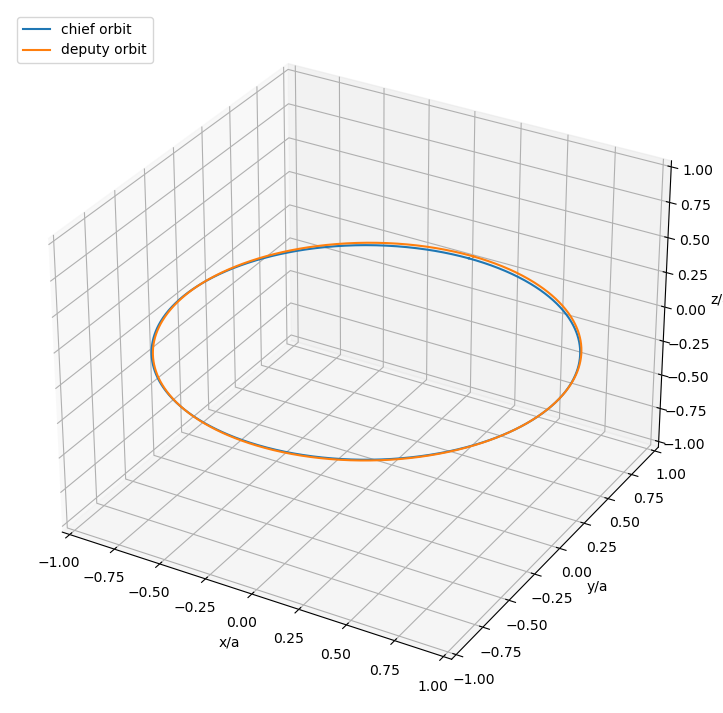

In [16]:
# deputy and chief orbits in ECI coordinate system
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.plot3D(solution.y[7] / r0, solution.y[6] / r0,
          solution.y[8] / r0, label="chief orbit")
ax.plot3D(deputy_pos[1] / r0, deputy_pos[0] / r0,
          deputy_pos[2] / r0, label="deputy orbit")
ax.set_xlabel("x/a")
ax.set_ylabel("y/a")
ax.set_zlabel("z/a")
ax.legend(loc="upper left")

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)


plt.show()


In [17]:
# Application of Lyapunov control functions
k = 3  # response coefficient
n_periods = 2  # simulation time in chief's orbital periods
xr = np.array([0, 0, 0])  # target relative distance
xrt = np.array([0, 0, 0])  # and relative velocity
thrust_constraint = np.array([0.25, 0.25, 0.25])  # thrust constarints
# mas = [/*realtive orbit*/ x, y, z, xt, yt, zt, /*chief position*/ x1, y1, z1, xt1, yt1, zt1]


def CWfunc(t, mas, n, k, xr, xrt, thr_cons):
    out = np.zeros(12)
    x, y, z, xt, yt, zt, x1, y1, z1, xt1, yt1, zt1 = mas

    # control law evaluation
    e = np.array([x, y, z]) - xr
    e.reshape((3, 1))
    et = np.array([xt, yt, zt]) - xrt
    e.reshape((3, 1))

    F1 = np.array([
        [3 * n**2, 0, 0],
        [0, 0, 0],
        [0, 0, -n**2]
    ])

    u = - (n**2 * np.eye(3) + F1) @ (e) - k * n * (et)
    u = np.where(u > thr_cons, thr_cons, u)
    u = np.where(u < -thr_cons, -thr_cons, u)

    out[0] = xt
    out[1] = yt
    out[2] = zt

    out[3] = 2 * n * yt + 3 * n**2 * x + u[0]
    out[4] = - 2 * n * xt + u[1]
    out[5] = - n**2 * z + u[2]

    out[6] = xt1
    out[7] = yt1
    out[8] = zt1

    out[9] = - n**2 * x1
    out[10] = - n**2 * y1
    out[11] = - n**2 * z1

    return out


mas0 = [69780, 139560, 104670, 7.5579, -
        151.116, 15.116, r0, 0, 0, 0, r0 * n0, 0]

solution = solve_ivp(CWfunc, (0, n_periods * (2*np.pi/float(n0))), mas0,
                     args=(n0, k, xr, xrt, thrust_constraint), max_step=(2*np.pi/float(n0)/1000))

print("number of samples: ", len(solution.t))

solution


number of samples:  2009


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.742e-07 ...  1.160e+04  1.160e+04]
        y: [[69780 69780.00000282834 ... -7055.196733960852
             -7052.118781166004]
            [139560 139559.99994344893 ... -886.6512384274071
             -888.4931051756137]
            ...
            [7557.93520992552 7557.935209925521 ... 7557.923242268787
             7557.935209925277]
            [0 0.0 ... 0.0 0.0]]
      sol: None
 t_events: None
 y_events: None
     nfev: 12050
     njev: 0
      nlu: 0

In [18]:
# calculating deputy position in ECI and thrust acceleration vector
deputy_pos = np.empty((3, 0))
thrust = np.empty((3, 0))

for x, y, z, xt, yt, zt, x1, y1, z1, xt1, yt1, zt1 in zip(*list(solution.y)):
    ez = np.array([x1, y1, z1])
    ez = ez / np.linalg.norm(ez)
    ey = np.cross([x1, y1, z1], [xt1, yt1, zt1])
    ey = ey / np.linalg.norm(np.double(ey))
    ex = np.cross(ey, ez)

    A = np.vstack((ez, ex, ey)).T

    x0, y0, z0 = (A @ np.array([[x], [y], [z]]) +
                  np.array([[x1], [y1], [z1]])).T[0]

    deputy_pos = np.concatenate((deputy_pos, [[x0], [y0], [z0]]), axis=1)

    # control law evaluation
    e = np.array([x, y, z]) - xr
    e.reshape((3, 1))
    et = np.array([xt, yt, zt]) - xrt
    e.reshape((3, 1))

    F1 = np.array([
        [3 * n0**2, 0, 0],
        [0, 0, 0],
        [0, 0, -n0**2]
    ])

    u = - (n0**2 * np.eye(3) + F1) @ (e) - k * n0 * (et)
    u = np.where(u > thrust_constraint, thrust_constraint, u)
    u = np.where(u < -thrust_constraint, -thrust_constraint, u)

    thrust = np.concatenate((thrust, u.reshape(3, 1)), axis=1)


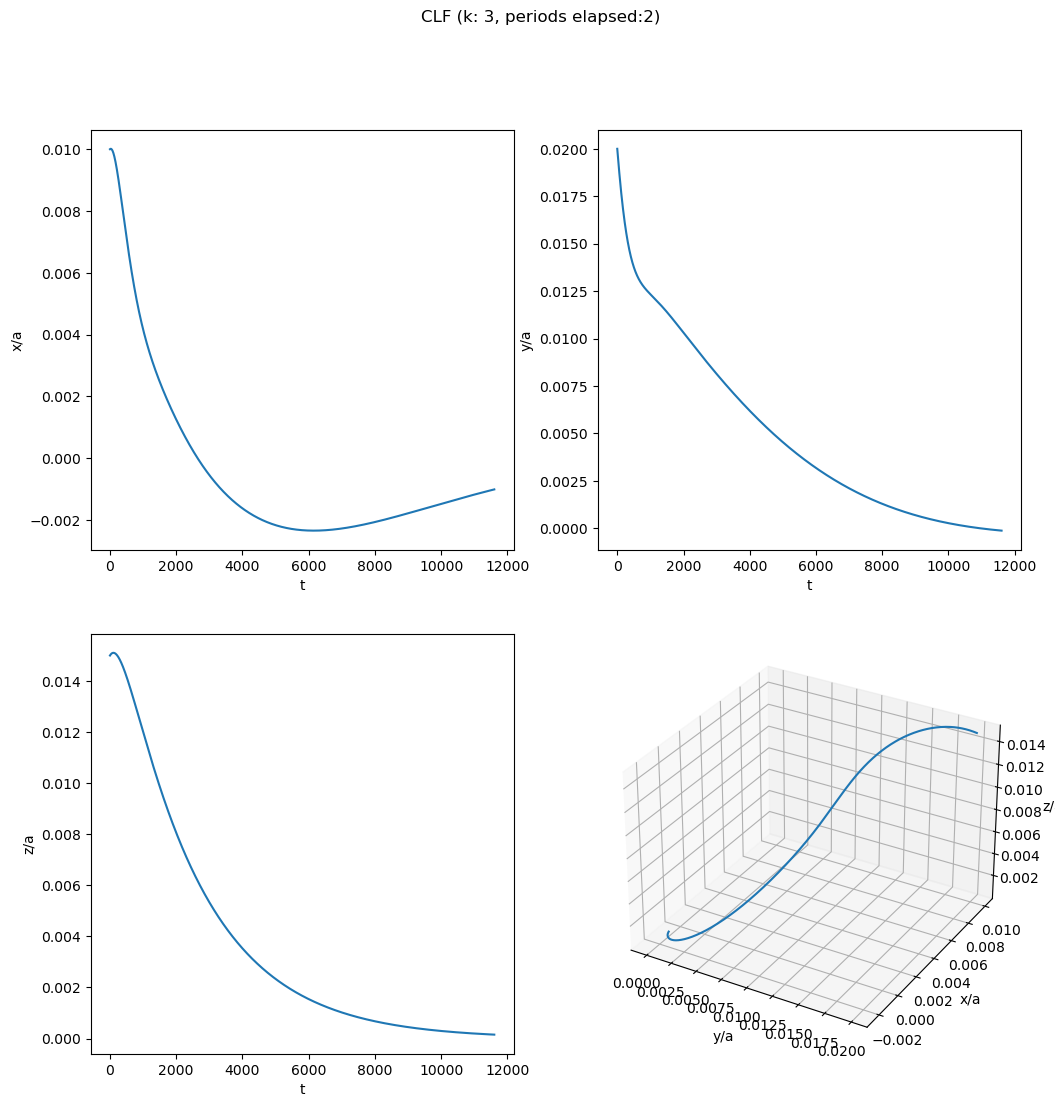

In [19]:
fig = plt.figure(figsize=(12, 12), dpi=100)
fig.suptitle(f"CLF (k: {k}, periods elapsed:{n_periods})")

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(solution.t, solution.y[0] / r0)
ax1.set_xlabel("t")
ax1.set_ylabel("x/a")

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(solution.t, solution.y[1] / r0)
ax2.set_xlabel("t")
ax2.set_ylabel("y/a")

ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(solution.t, solution.y[2] / r0)
ax3.set_xlabel("t")
ax3.set_ylabel("z/a")

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot3D(solution.y[1] / r0, solution.y[0] / r0, solution.y[2] / r0)
ax4.set_xlabel("y/a")
ax4.set_ylabel("x/a")
ax4.set_zlabel("z/a")

plt.show()


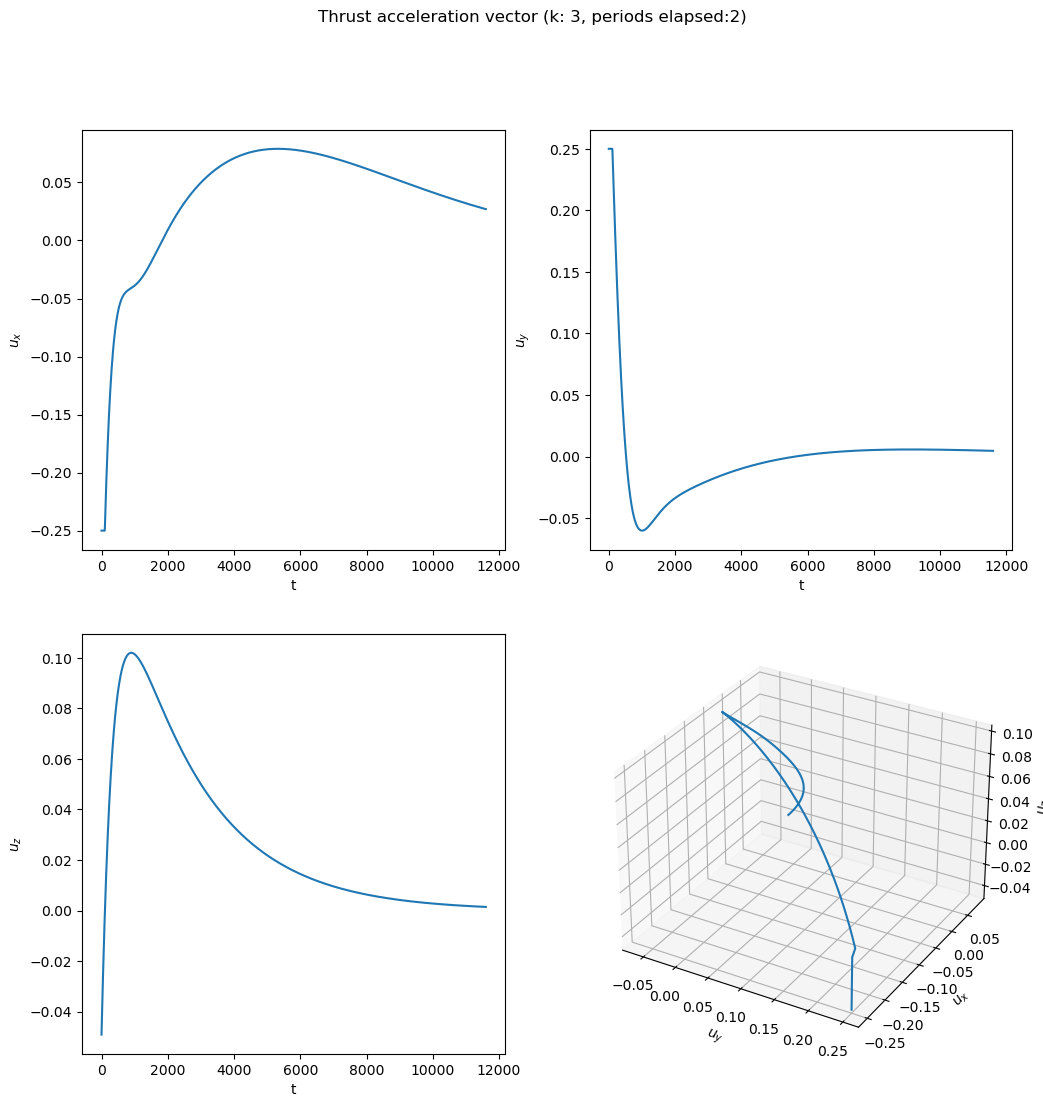

In [20]:
fig = plt.figure(figsize=(12, 12), dpi=100)
fig.suptitle(
    f"Thrust acceleration vector (k: {k}, periods elapsed:{n_periods})")

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(solution.t, thrust[0])
ax1.set_xlabel("t")
ax1.set_ylabel(r"$u_x$")

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(solution.t, thrust[1])
ax2.set_xlabel("t")
ax2.set_ylabel(r"$u_y$")

ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(solution.t, thrust[2])
ax3.set_xlabel("t")
ax3.set_ylabel(r"$u_z$")

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot3D(thrust[1], thrust[0], thrust[2])
ax4.set_xlabel(r"$u_y$")
ax4.set_ylabel(r"$u_x$")
ax4.set_zlabel(r"$u_z$")

plt.show()


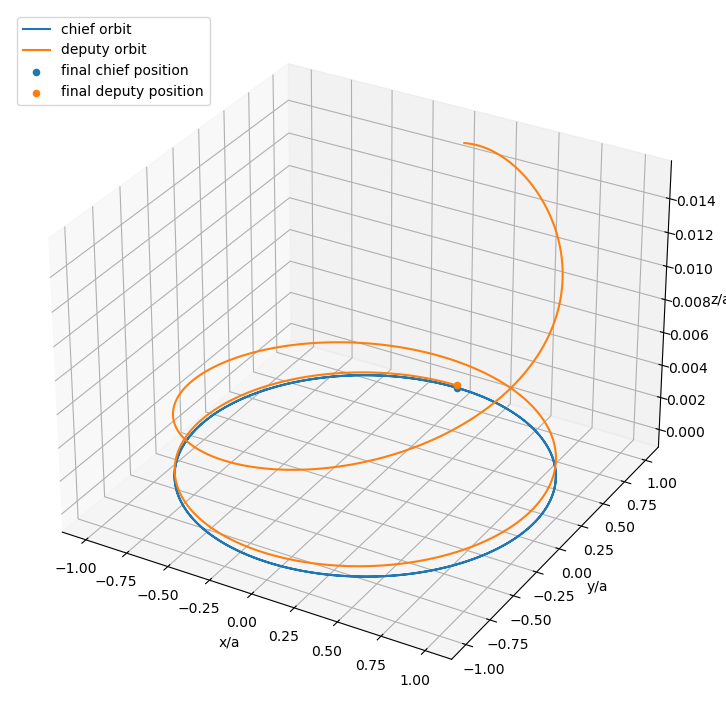

In [21]:
# deputy and chief orbits in ECI coordinate system
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.plot3D(solution.y[7] / r0, solution.y[6] / r0,
          solution.y[8] / r0, label="chief orbit")
ax.plot3D(deputy_pos[1] / r0, deputy_pos[0] / r0,
          deputy_pos[2] / r0, label="deputy orbit")

ax.scatter(solution.y[7][-1] / r0, solution.y[6][-1] / r0,
           solution.y[8][-1] / r0, marker="o", label="final chief position")
ax.scatter(deputy_pos[1][-1] / r0, deputy_pos[0][-1] / r0,
           deputy_pos[2][-1] / r0, marker="o", label="final deputy position")

ax.set_xlabel("x/a")
ax.set_ylabel("y/a")
ax.set_zlabel("z/a")

ax.legend(loc="upper left")

plt.show()


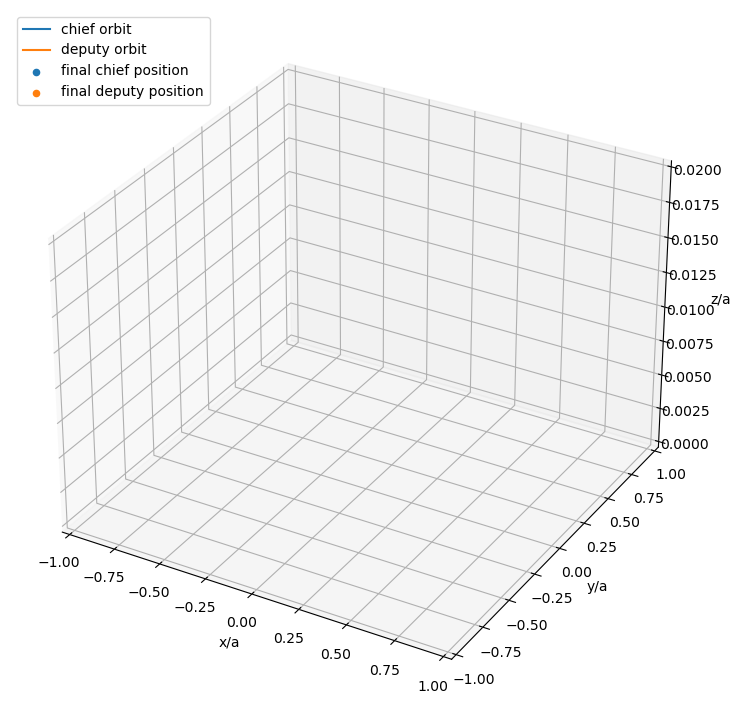

MovieWriter Pillow unavailable; using Pillow instead.


In [22]:
# animation of satellites' flying
#%matplotlib qt

# note: rendering can take several minutes

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
line1, = ax.plot3D([], [], [], label="chief orbit")
line2, = ax.plot3D([], [], [], label="deputy orbit")
c_pos, d_pos = ax.scatter([], [], [], marker="o", label="final chief position"),  ax.scatter(
    [], [], [], marker="o", label="final deputy position")


def update(frame):
    c_pos._offsets3d = ([solution.y[7, frame - 1] / r0],
                        [solution.y[6, frame - 1] / r0], [solution.y[8, frame - 1] / r0])
    d_pos._offsets3d = ([deputy_pos[1, frame - 1] / r0],
                        [deputy_pos[0, frame - 1] / r0], [deputy_pos[2, frame - 1] / r0])
    line1.set_data(solution.y[7, :frame] / r0, solution.y[6, :frame] / r0)
    line1.set_3d_properties(solution.y[8, :frame] / r0)
    line2.set_data(deputy_pos[1, :frame] / r0, deputy_pos[0, :frame] / r0)
    line2.set_3d_properties(deputy_pos[2, :frame] / r0)
    return (c_pos, d_pos, line1, line2)


# Setting the axes properties
ax.set_xlim3d([-1.0, 1.0])
ax.set_xlabel('x/a')

ax.set_ylim3d([-1.0, 1.0])
ax.set_ylabel('y/a')

ax.set_zlim3d([0.0, 0.02])
ax.set_zlabel('z/a')

ax.legend(loc="upper left")

ani = animation.FuncAnimation(fig=fig, func=update, frames=np.linspace(
    0, len(solution.t), 100, dtype=np.int32), interval=0.1, repeat=True)

plt.show()

ani.save(filename="sat.gif", writer="Pillow")


In [28]:
# Application of Lyapunov control functions
k = 3  # response coefficient
n_periods = 2  # simulation time in chief's orbital periods
xr = np.array([0, 0, 0])  # target relative distance
xrt = np.array([0, 0, 0])  # and relative velocity
thrust_constraint = np.array([1, 1, 1])  # thrust constarints
# mas = [/*realtive orbit*/ x, y, z, xt, yt, zt, /*chief position*/ x1, y1, z1, xt1, yt1, zt1]


def CWfunc(t, mas, n, k, xr, xrt, thr_cons):
    out = np.zeros(12)
    x, y, z, xt, yt, zt, x1, y1, z1, xt1, yt1, zt1 = mas

    # control law evaluation
    e = np.array([x, y, z]) - xr
    e.reshape((3, 1))
    et = np.array([xt, yt, zt]) - xrt
    e.reshape((3, 1))

    F1 = np.array([
        [3 * n**2, 0, 0],
        [0, 0, 0],
        [0, 0, -n**2]
    ])

    u = - (n**2 * np.eye(3) + F1) @ (e) - k * n * (et)
    u = np.where(u > thr_cons, thr_cons, u)
    u = np.where(u < -thr_cons, -thr_cons, u)

    out[0] = xt
    out[1] = yt
    out[2] = zt

    out[3] = 2 * n * yt + 3 * n**2 * x + u[0]
    out[4] = - 2 * n * xt + u[1]
    out[5] = - n**2 * z + u[2]

    out[6] = xt1
    out[7] = yt1
    out[8] = zt1

    out[9] = - n**2 * x1
    out[10] = - n**2 * y1
    out[11] = - n**2 * z1

    return out


mas0 = [0, 0, 1000, 7.5579, 0, 0, r0, 0, 0, 0, r0 * n0, 0]

solution = solve_ivp(CWfunc, (0, n_periods * (2*np.pi/float(n0))), mas0,
                     args=(n0, k, xr, xrt, thrust_constraint), max_step=(2*np.pi/float(n0)/1000))

print("number of samples: ", len(solution.t))

solution

number of samples:  2009


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.646e-07 ...  1.160e+04  1.160e+04]
        y: [[0 1.999921798922223e-06 ... 14.374813548305692
             14.2994165887876]
            [0 -5.731879960246414e-16 ... 120.91612263071576
             120.84028386958582]
            ...
            [7557.93520992552 7557.935209925521 ... 7557.898924924268
             7557.935209925265]
            [0 0.0 ... 0.0 0.0]]
      sol: None
 t_events: None
 y_events: None
     nfev: 12050
     njev: 0
      nlu: 0

In [29]:
# calculating deputy position in ECI and thrust acceleration vector
deputy_pos = np.empty((3, 0))
thrust = np.empty((3, 0))

for x, y, z, xt, yt, zt, x1, y1, z1, xt1, yt1, zt1 in zip(*list(solution.y)):
    ez = np.array([x1, y1, z1])
    ez = ez / np.linalg.norm(ez)
    ey = np.cross([x1, y1, z1], [xt1, yt1, zt1])
    ey = ey / np.linalg.norm(np.double(ey))
    ex = np.cross(ey, ez)

    A = np.vstack((ez, ex, ey)).T

    x0, y0, z0 = (A @ np.array([[x], [y], [z]]) +
                  np.array([[x1], [y1], [z1]])).T[0]

    deputy_pos = np.concatenate((deputy_pos, [[x0], [y0], [z0]]), axis=1)

    # control law evaluation
    e = np.array([x, y, z]) - xr
    e.reshape((3, 1))
    et = np.array([xt, yt, zt]) - xrt
    e.reshape((3, 1))

    F1 = np.array([
        [3 * n0**2, 0, 0],
        [0, 0, 0],
        [0, 0, -n0**2]
    ])

    u = - (n0**2 * np.eye(3) + F1) @ (e) - k * n0 * (et)
    u = np.where(u > thrust_constraint, thrust_constraint, u)
    u = np.where(u < -thrust_constraint, -thrust_constraint, u)

    thrust = np.concatenate((thrust, u.reshape(3, 1)), axis=1)


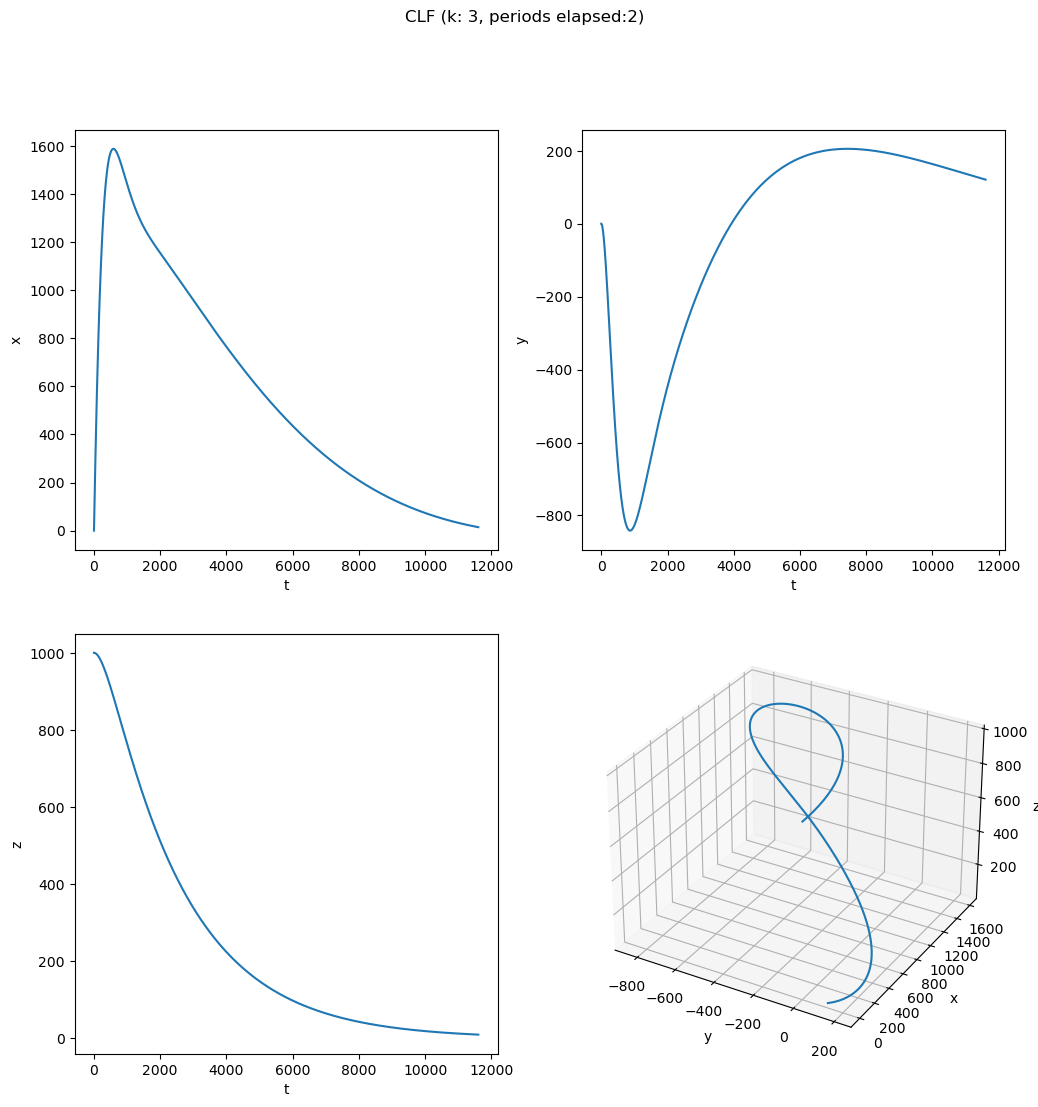

In [32]:
fig = plt.figure(figsize=(12, 12), dpi=100)
fig.suptitle(f"CLF (k: {k}, periods elapsed:{n_periods})")

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(solution.t, solution.y[0])
ax1.set_xlabel("t")
ax1.set_ylabel("x")

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(solution.t, solution.y[1])
ax2.set_xlabel("t")
ax2.set_ylabel("y")

ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(solution.t, solution.y[2])
ax3.set_xlabel("t")
ax3.set_ylabel("z")

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot3D(solution.y[1], solution.y[0], solution.y[2])
ax4.set_xlabel("y")
ax4.set_ylabel("x")
ax4.set_zlabel("z")

plt.show()


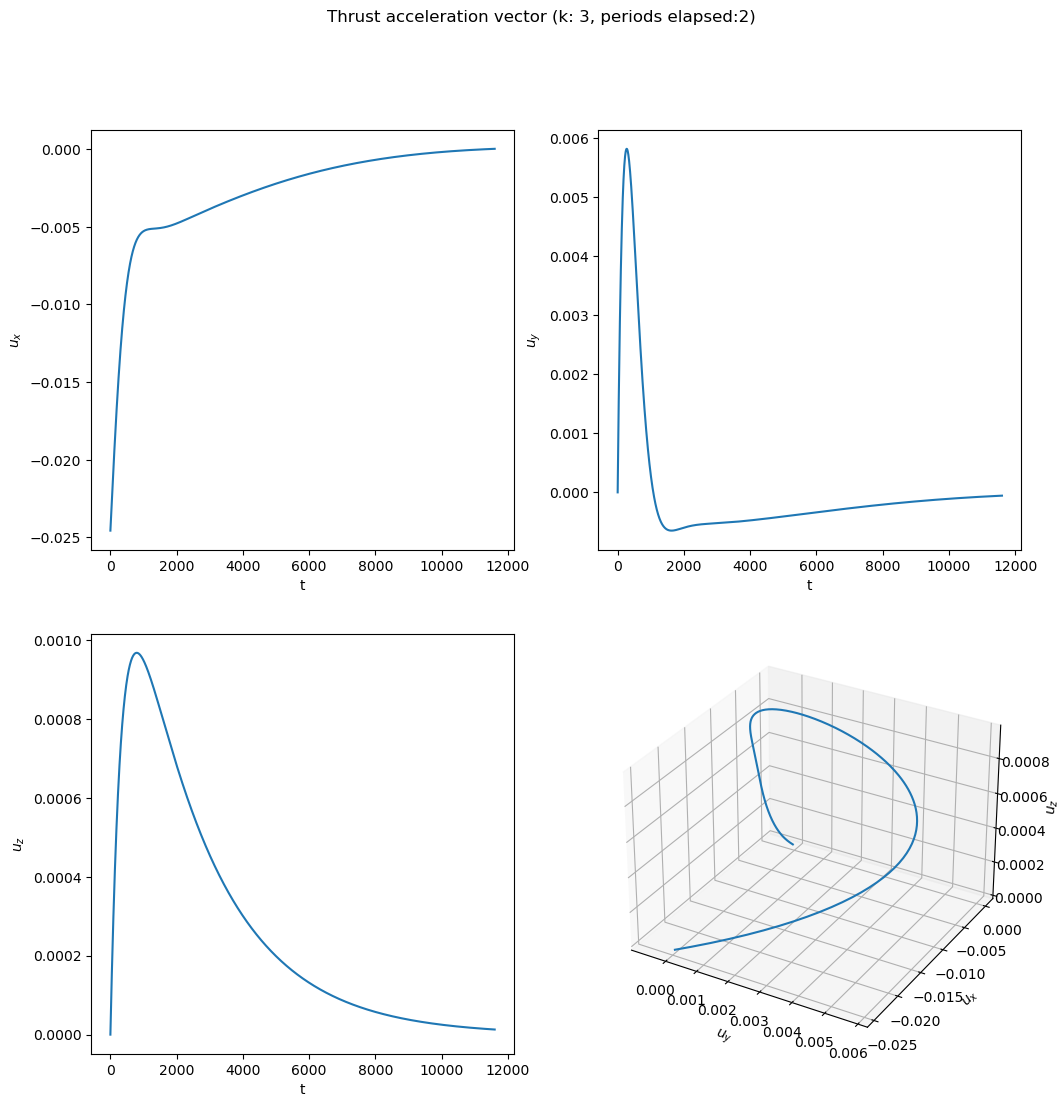

In [26]:
fig = plt.figure(figsize=(12, 12), dpi=100)
fig.suptitle(
    f"Thrust acceleration vector (k: {k}, periods elapsed:{n_periods})")

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(solution.t, thrust[0])
ax1.set_xlabel("t")
ax1.set_ylabel(r"$u_x$")

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(solution.t, thrust[1])
ax2.set_xlabel("t")
ax2.set_ylabel(r"$u_y$")

ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(solution.t, thrust[2])
ax3.set_xlabel("t")
ax3.set_ylabel(r"$u_z$")

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot3D(thrust[1], thrust[0], thrust[2])
ax4.set_xlabel(r"$u_y$")
ax4.set_ylabel(r"$u_x$")
ax4.set_zlabel(r"$u_z$")

plt.show()


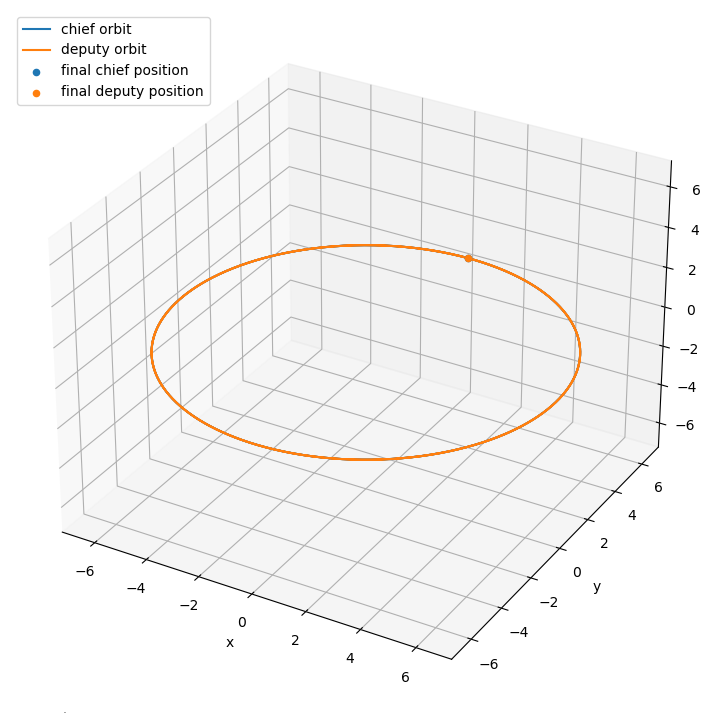

In [35]:
# deputy and chief orbits in ECI coordinate system
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.plot3D(solution.y[7], solution.y[6],
          solution.y[8], label="chief orbit")
ax.plot3D(deputy_pos[1], deputy_pos[0],
          deputy_pos[2], label="deputy orbit")

ax.scatter(solution.y[7][-1], solution.y[6][-1],
           solution.y[8][-1], marker="o", label="final chief position")
ax.scatter(deputy_pos[1][-1], deputy_pos[0][-1],
           deputy_pos[2][-1], marker="o", label="final deputy position")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim(-r0, r0)
ax.set_ylim(-r0, r0)
ax.set_zlim(-r0, r0)

ax.legend(loc="upper left")

plt.show()
# множитель 10**6 почему-то не отображается